In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyrsm as rsm
import numpy as np
import datetime
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
import gc
import os

import vaex
import vaex.ml
from sklearn.linear_model import SGDRegressor
from vaex.ml.sklearn import IncrementalPredictor
        
RANDOM_SEED = 42

In [2]:
dv = vaex.from_csv('taxi_trip_18.csv', convert=True, chunk_size=5_000_000)

In [3]:
dv_0 = vaex.open('taxi_trip_18.csv.hdf5')
day_week = pd.read_csv('dict.csv')
day_of_week = vaex.from_pandas(day_week)
dv_0_cleaned = dv_0[dv_0['Trip Seconds'] != 0]
cleaned = dv_0_cleaned[dv_0_cleaned['Trip Miles'] != 0]

no_pickup = cleaned[cleaned['Pickup Community Area'] == cleaned['Pickup Community Area']]
no_pickup = no_pickup[no_pickup['Pickup Centroid Latitude'] == no_pickup['Pickup Centroid Latitude']]
no_pickup = no_pickup[no_pickup['Pickup Centroid Longitude'] == no_pickup['Pickup Centroid Longitude']]

no_drop = no_pickup[no_pickup['Dropoff Community Area'] == no_pickup['Dropoff Community Area']]
no_drop = no_drop[no_drop['Dropoff Centroid Latitude'] == no_drop['Dropoff Centroid Latitude']]
no_drop = no_drop[no_drop['Dropoff Centroid Longitude'] == no_drop['Dropoff Centroid Longitude']]

no_drop = no_drop[no_drop['Trip Seconds'] == no_drop['Trip Seconds']]
no_drop = no_drop[no_drop['Trip Miles'] == no_drop['Trip Miles']]

new_df = no_drop.join(day_of_week, left_on = 'Trip Start Timestamp', right_on = 'Tag', how = 'left')
new_df['trip_dur'] = new_df['Trip Seconds'] / 60

/home/jovyan/.rsm-msba/lib/python3.8/site-packages/vaex/viz/mpl.py:46: UserWarning: `plot1d` is deprecated and it will be removed in version 5.x. Please use `df.viz.histogram` instead.
  warnings.warn('`plot1d` is deprecated and it will be removed in version 5.x. Please use `df.viz.histogram` instead.')


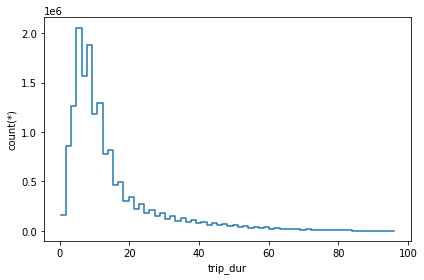

In [6]:
new_df.plot1d(new_df.trip_dur, limits = '99.7%')

In [7]:
fin_df = new_df[['Month', 'Day', 'Day_num', 'hour_num', 'trip_dur', 'Trip Miles', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']]

In [8]:
# fin_df.shape

In [9]:
fin_df['is_weekend'] = (fin_df.Day_num >= 5).astype('int')

fin_df.rename('Trip Miles', 'trip_miles')

fin_df.rename('Pickup Centroid Latitude', 'pick_lat')
fin_df.rename('Pickup Centroid Longitude', 'pick_long')

fin_df.rename('Dropoff Centroid Latitude', 'drop_lat')
fin_df.rename('Dropoff Centroid Longitude', 'drop_long')

'drop_long'

In [10]:
fin_df = fin_df[(fin_df.trip_dur > 3) & (fin_df.trip_dur < 20)]

In [11]:
def angle_travel(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

fin_df['angle'] = angle_travel(fin_df['pick_long'], fin_df['pick_lat'], fin_df['drop_long'], fin_df['drop_lat'])

In [12]:
pca_pickup = vaex.ml.PCA(features = ['pick_long', 'pick_lat'], n_components = 2, prefix = 'PCA_pickup_')
fin_df = pca_pickup.fit_transform(fin_df)

pca_dropoff = vaex.ml.PCA(features = ['drop_long', 'drop_lat'], n_components = 2, prefix = 'PCA_dropoff_')
fin_df = pca_dropoff.fit_transform(fin_df)

/home/jovyan/.rsm-msba/lib/python3.8/site-packages/vaex/viz/mpl.py:311: UserWarning: `plot` is deprecated and it will be removed in version 5.x. Please `df.viz.heatmap` instead.
  warnings.warn('`plot` is deprecated and it will be removed in version 5.x. Please `df.viz.heatmap` instead.')


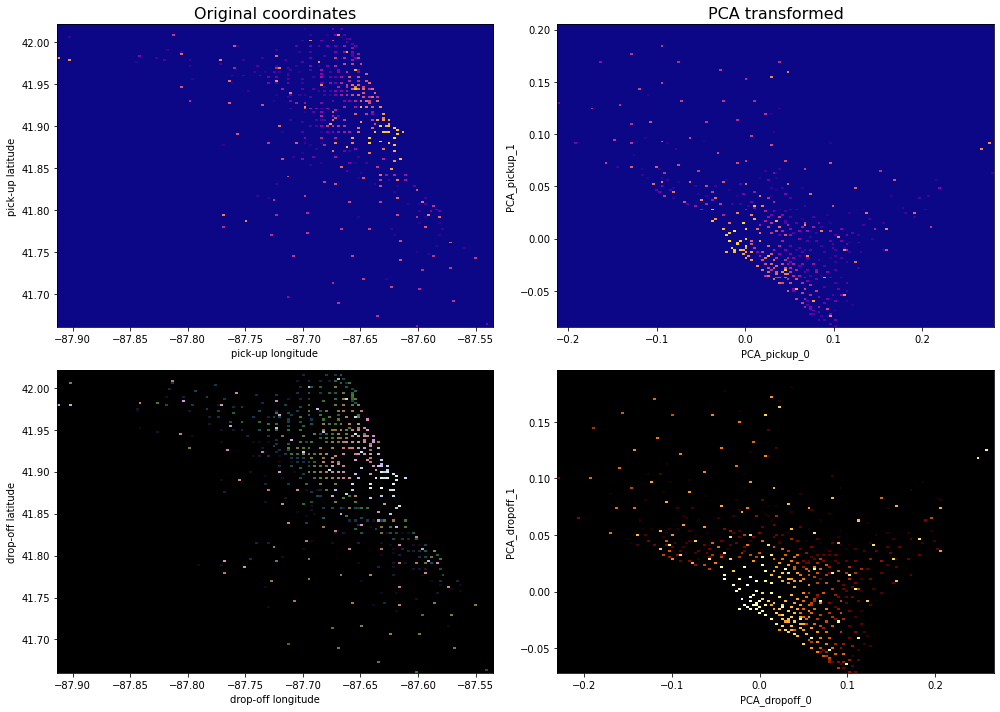

In [13]:
# Visualise the PCA results to make sure they makes sense
plt.figure(figsize=(14, 10))

plt.subplot(221)
plt.title('Original coordinates', fontsize=16)
fin_df.plot(fin_df.pick_long, fin_df.pick_lat,
              limits='minmax', f='log1p', shape=156,
              colormap='plasma', colorbar=False, 
              xlabel='pick-up longitude', ylabel='pick-up latitude')

plt.subplot(222)
plt.title('PCA transformed', fontsize=16)
fin_df.plot(fin_df.PCA_pickup_0, fin_df.PCA_pickup_1,
              limits='minmax', f='log1p', shape=156,
              colormap='plasma', colorbar=False,
              xlabel='PCA_pickup_0', ylabel='PCA_pickup_1')
              

plt.subplot(223)
fin_df.plot(fin_df.drop_long, fin_df.drop_lat,
              limits='minmax', f='log1p', shape=150,
              colormap='cubehelix', colorbar=False,
              xlabel='drop-off longitude', ylabel='drop-off latitude')

plt.subplot(224)
fin_df.plot(fin_df.PCA_dropoff_0, fin_df.PCA_dropoff_1,
              limits='minmax', f='log1p', shape=150,
            colorbar=False,
              xlabel='PCA_dropoff_0', ylabel='PCA_dropoff_1')

plt.tight_layout()
plt.show()

In [14]:
#time
cycl_time = vaex.ml.CycleTransformer(features = ['hour_num'], n = 24)
fin_df = cycl_time.fit_transform(fin_df)

#day
cycl_day = vaex.ml.CycleTransformer(features = ['Day_num'], n = 7)
fin_df = cycl_day.fit_transform(fin_df)

#month
cycl_month = vaex.ml.CycleTransformer(features = ['Month'], n = 12)
fin_df = cycl_month.fit_transform(fin_df)

#angle
cycl_angle = vaex.ml.CycleTransformer(features = ['angle'], n = 24)
fin_df = cycl_angle.fit_transform(fin_df)

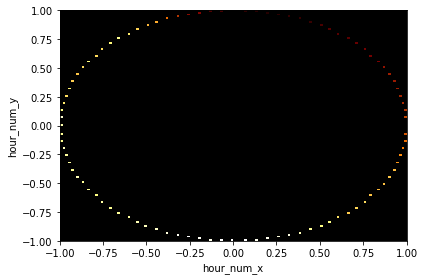

In [15]:
fin_df.viz.heatmap(x = 'hour_num_x', y = 'hour_num_y', shape = 128, limits = [-1, 1], colorbar = False)
plt.show()

In [16]:
# standard scalar on trip miles
standard_scaler = vaex.ml.StandardScaler(features = ['trip_miles'])
fin_df = standard_scaler.fit_transform(fin_df)

In [17]:
# final list of features to feed into model
features = fin_df.get_column_names(regex = 'PCA*') + \
fin_df.get_column_names(regex = 'standard_scaled') + \
fin_df.get_column_names(regex = '.*_x') + \
fin_df.get_column_names(regex = '.*_y') + \
['is_weekend']

In [18]:
# fin_df.head(5)[features]

In [19]:
model = SGDRegressor(learning_rate = 'constant', eta0 = 0.0001)
target = 'trip_dur'
vaex_model = IncrementalPredictor(features = features, 
                                 target = target, 
                                 model = model, 
                                 batch_size = 11_000_000, 
                                 num_epochs = 1, 
                                 shuffle = False, 
                                 prediction_name = 'predicted_duration_min')

vaex_model.fit(df = fin_df, progress = 'widget')

In [20]:
fin_df = vaex_model.transform(fin_df)
fin_df.head(5)['trip_dur', 'predicted_duration_min']

#,trip_dur,predicted_duration_min
0,6,6.47064
1,4,11.4939
2,6,8.05262
3,7,7.65239
4,12,11.2385


In [21]:
fin_df['pred_final'] = fin_df.predicted_duration_min.clip(3, 20)

In [22]:
test_set = pd.read_csv('Taxi_Trips.csv')
test_df = vaex.from_pandas(test_set)

In [23]:
test_df_cleaned = test_df[test_df['Trip Seconds'] != 0]
cleaned = test_df_cleaned[test_df_cleaned['Trip Miles'] != 0]

day_week_19 = pd.read_csv('dict_2.csv')
day_of_week_19 = vaex.from_pandas(day_week_19)

no_pickup = cleaned[cleaned['Pickup Community Area'] == cleaned['Pickup Community Area']]
no_pickup = no_pickup[no_pickup['Pickup Centroid Latitude'] == no_pickup['Pickup Centroid Latitude']]
no_pickup = no_pickup[no_pickup['Pickup Centroid Longitude'] == no_pickup['Pickup Centroid Longitude']]

no_drop = no_pickup[no_pickup['Dropoff Community Area'] == no_pickup['Dropoff Community Area']]
no_drop = no_drop[no_drop['Dropoff Centroid Latitude'] == no_drop['Dropoff Centroid Latitude']]
no_drop = no_drop[no_drop['Dropoff Centroid Longitude'] == no_drop['Dropoff Centroid Longitude']]

no_drop = no_drop[no_drop['Trip Seconds'] == no_drop['Trip Seconds']]
no_drop = no_drop[no_drop['Trip Miles'] == no_drop['Trip Miles']]

new_df = no_drop.join(day_of_week_19, left_on = 'Trip Start Timestamp', right_on = 'Tag', how = 'left')
new_df['trip_dur'] = new_df['Trip Seconds'] / 60

df_test = new_df[['Month', 'Day', 'Day_num', 'hour_num', 'trip_dur', 'Trip Miles', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']]

In [24]:
# Get the state from the training DataFrame
state = fin_df.state_get()
# Set it on the test set
df_test.state_set(state)
# Preview the test set
df_test.head(5)[features + ['predicted_duration_min', 'pred_final']]

# Save the state to disk
#fin_df.state_write('./trip_duration_model.json')

/home/jovyan/.rsm-msba/lib/python3.8/site-packages/vaex/dataframe.py:2625: UserWarning: The state wants to rename Pickup Community Area to __Pickup Community Area, but __Pickup Community Area was not found, ignoring the rename
  warnings.warn(f'The state wants to rename {old} to {new}, but {new} was not found, ignoring the rename')
/home/jovyan/.rsm-msba/lib/python3.8/site-packages/vaex/dataframe.py:2625: UserWarning: The state wants to rename Trip Seconds to __Trip Seconds, but __Trip Seconds was not found, ignoring the rename
  warnings.warn(f'The state wants to rename {old} to {new}, but {new} was not found, ignoring the rename')
/home/jovyan/.rsm-msba/lib/python3.8/site-packages/vaex/dataframe.py:2625: UserWarning: The state wants to rename Dropoff Community Area to __Dropoff Community Area, but __Dropoff Community Area was not found, ignoring the rename
  warnings.warn(f'The state wants to rename {old} to {new}, but {new} was not found, ignoring the rename')


#,PCA_pickup_0,PCA_pickup_1,PCA_dropoff_0,PCA_dropoff_1,standard_scaled_trip_miles,hour_num_x,Day_num_x,Month_x,angle_x,hour_num_y,Day_num_y,Month_y,angle_y,is_weekend,predicted_duration_min,pred_final
0,-0.0101374,-0.0141019,-0.0116683,-0.0077697,-0.503884,1,0.62349,1,-0.286681,0,0.781831,0,0.958026,0,7.52876,7.52876
1,-0.0160127,-0.00920557,-0.0078682,-0.00356403,-0.409121,1,0.62349,1,-0.960748,0,0.781831,0,0.277423,0,8.05071,8.05071
2,-0.0101374,-0.0141019,-0.0116683,-0.0077697,-0.503884,1,0.62349,1,-0.286681,0,0.781831,0,0.958026,0,7.52876,7.52876
3,0.0102698,0.0306561,-0.0217506,0.00147704,-0.598646,1,0.62349,1,-0.948821,0,0.781831,0,0.315815,0,7.52527,7.52527
4,-0.0177665,-0.00315082,-0.00270428,-0.000327325,-0.409121,1,0.62349,1,-0.506363,0,0.781831,0,0.862321,0,7.93817,7.93817


In [25]:
fin_df['abs_diff'] = np.abs(fin_df.pred_final - fin_df.trip_dur)
fin_df['diff'] = (fin_df.pred_final - fin_df.trip_dur) ** 2

df_test['abs_diff'] = np.abs(df_test.pred_final - df_test.trip_dur)
df_test['diff'] = (df_test.pred_final - df_test.trip_dur) ** 2

In [26]:
to_pd_train = fin_df[['Month', 'trip_dur', 'pred_final', 'abs_diff', 'diff']]
to_pd_test = df_test[['Month', 'trip_dur', 'pred_final', 'abs_diff', 'diff']]

In [27]:
pd_train = to_pd_train.to_pandas_df()
pd_test = to_pd_test.to_pandas_df()

In [28]:
mae_train = pd_train.abs_diff.mean() 
mse_train = pd_train['diff'].mean() 

mae_test = pd_test.abs_diff.mean() 
mse_test = pd_test['diff'].mean() 

print(f'The train mean absolute error is {mae_train:.3} minuts.')
print(f'The train mean squared error is {mse_train:.3} minutes squared.')
print('')
print(f'The test mean absolute error is {mae_test:.3} minuts.')
print(f'The test mean squared error is {mse_test:.3} minutes squared.')

The train mean absolute error is 2.55 minuts.
The train mean squared error is 10.1 minutes squared.

The test mean absolute error is 2.47 minuts.
The test mean squared error is 10.4 minutes squared.


In [51]:
plt_test_2 = pd_test[(pd_test.trip_dur % 1 != 0) & (pd_test.pred_final % 1 != 0)]

Text(0, 0.5, 'Estimated durations [min]')

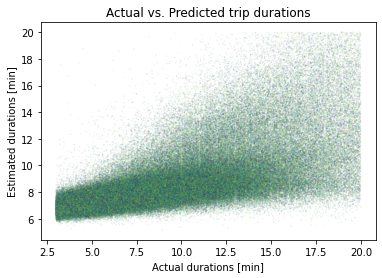

In [61]:
# plt_test = pd_test[pd_test.pred_final % 1 != 0]

colors = np.random.rand(397788)
area = (30 * np.random.rand(50))**2  # 0 to 15 point radii
plt.scatter(x = 'trip_dur', y = 'pred_final', s = 0.01, data = plt_test_2, c=colors, alpha = 0.5)

plt.title('Actual vs. Predicted trip durations')
plt.xlabel('Actual durations [min]')
plt.ylabel('Estimated durations [min]')

In [55]:

# pd_test.scatterplot(x='trip_dur', y='pred_final', shape=64, limits=[3, 20])
# colors = np.random.rand(700348)
# area = (30 * np.random.rand(50))**2  # 0 to 15 point radii
# plt.scatter(x = 'trip_dur', y = 'pred_final', s = 0.0001, data = pd_test, c=colors, alpha = 0.5)

# plt.title('Actual vs predicted trip durations')
# plt.xlabel('Actual durations [min]')
# plt.ylabel('Estimated durations [min]')

(array([2.97796e+05, 2.42298e+05, 8.97240e+04, 3.49980e+04, 1.96040e+04,
        1.02700e+04, 4.52100e+03, 1.09400e+03, 3.30000e+01, 1.00000e+01]),
 array([5.11263660e-06, 1.69833793e+00, 3.39667076e+00, 5.09500358e+00,
        6.79333640e+00, 8.49166922e+00, 1.01900020e+01, 1.18883349e+01,
        1.35866677e+01, 1.52850005e+01, 1.69833333e+01]),
 <BarContainer object of 10 artists>)

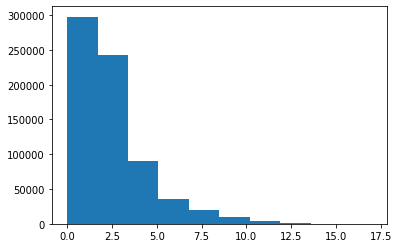

In [60]:
plt.hist(pd_test.abs_diff)

In [62]:
# See what percentage of the trips durations are predicted with an absolute error less than 5 minutes.
num_abs_err_under_5_min = plt_test_2[plt_test_2.abs_diff< 5].shape[0]
num_trips = len(plt_test_2)
err_perc = num_abs_err_under_5_min / num_trips * 100

print(f'{err_perc:.3}% of the trips durations in the test set were predicted within an absolute error of 5 minutes.')


90.9% of the trips durations in the test set were predicted within an absolute error of 5 minutes.


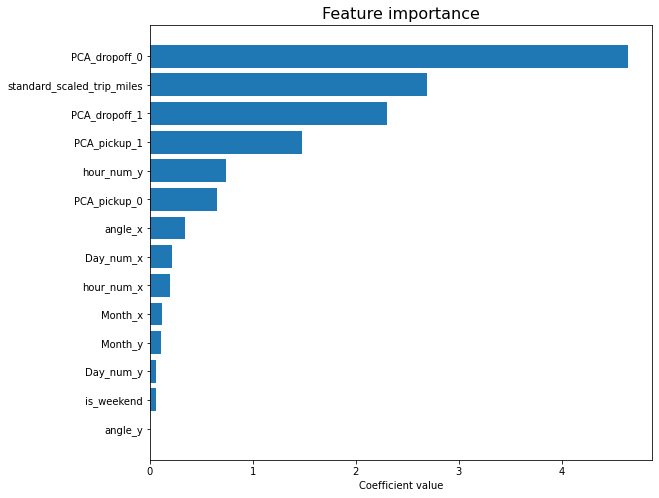

In [32]:
# Feature importance

# Sort indices of the features by their importance 
ind = np.argsort(np.abs(vaex_model.model.coef_))
# Sort the coefficients 
coef_ = np.abs(model.coef_[ind])
# Sort the features
features_ = np.array(features)[ind]

# Plot the feature importance
n_features = len(coef_)

plt.figure(figsize=(9, 8))
plt.barh(y=range(n_features), width=coef_)
plt.yticks(ticks=range(n_features), labels=features_)
plt.title('Feature importance', fontsize=16)
plt.xlabel('Coefficient value')
plt.show()